In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install imageio
!pip install gdown
!pip install tensorflow

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [3]:
# if you are using your personal computer run this query
physical_devices = tf.config.list_physical_devices('GPU')
try:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
   pass 

# 1. Build Data Loading Functions

In [4]:
#Download de Data in the specific url and select 'data.zip' file
url = 'https://drive.google.com/uc?id=1U_-7RFaknRoUQiQ-AJSGAak2Q0_g1L-S&export=download&confirm=t&uuid=63c9914b-1d78-48ae-a1aa-95aec96c428d'
output = 'data.zip'
gdown.download(url, output, quiet=False)
#Extract all the files in 'data.zip'
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1U_-7RFaknRoUQiQ-AJSGAak2Q0_g1L-S&export=download&confirm=t&uuid=63c9914b-1d78-48ae-a1aa-95aec96c428d
To: d:\LipRead\data.zip
100%|██████████| 423M/423M [00:06<00:00, 65.7MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    #Isolate the mouth frame
    frames.append(frame[190:236,80:220,:])
  cap.release()
  
  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
char_to_num(['m','a','t','h'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([13,  1, 20,  8], dtype=int64)>

In [10]:
num_to_char([13,  1, 20,  8])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'm', b'a', b't', b'h'], dtype=object)>

In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [14]:
test_path = r'data\s1\bbal6n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'data\\s1\\bbal6n.mpg'

In [16]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1]

'bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [18]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.19734782],
          [ 0.07893913]],
 
         [[ 1.4603739 ],
          [ 1.4603739 ],
          [ 1.4209043 ],
          ...,
          [ 0.15787826],
          [ 0.07893913],
          [ 0.03946957]],
 
         [[ 1.4209043 ],
          [ 1.4209043 ],
          [ 1.3814348 ],
          ...,
          [ 0.07893913],
          [ 0.07893913],
          [ 0.07893913]],
 
         ...,
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.94633   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          ...,
          [ 9.90686   ],
          [ 9.867392  ],
          [ 9.867392  ]],
 
         [[ 0.94726956],
          [ 0.94726956],
          [ 0.94726956],
          

In [19]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [20]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

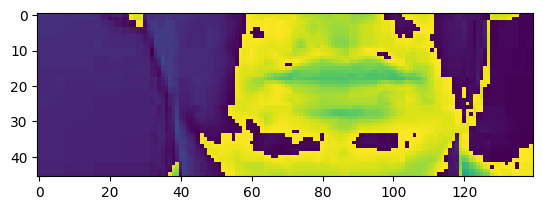

In [21]:
plt.imshow(frames[0])

In [22]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [23]:
num_to_char(alignments.numpy())

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [24]:
[bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]

['b',
 'i',
 'n',
 ' ',
 'b',
 'l',
 'u',
 'e',
 ' ',
 'a',
 't',
 ' ',
 'l',
 ' ',
 's',
 'i',
 'x',
 ' ',
 'n',
 'o',
 'w']

In [25]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [26]:
#Pure string process
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [27]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [28]:
data.as_numpy_iterator().next()

(array([[[[[1.3723171 ],
           [1.4835861 ],
           [1.4464964 ],
           ...,
           [0.37089652],
           [0.37089652],
           [0.33380687]],
 
          [[1.3723171 ],
           [1.4835861 ],
           [1.3723171 ],
           ...,
           [0.37089652],
           [0.37089652],
           [0.33380687]],
 
          [[1.4094068 ],
           [1.4094068 ],
           [1.4094068 ],
           ...,
           [0.33380687],
           [0.33380687],
           [0.33380687]],
 
          ...,
 
          [[1.0755999 ],
           [1.0385102 ],
           [1.0385102 ],
           ...,
           [0.03708965],
           [0.03708965],
           [0.03708965]],
 
          [[1.0385102 ],
           [1.0385102 ],
           [1.0385102 ],
           ...,
           [0.03708965],
           [0.03708965],
           [0.03708965]],
 
          [[1.0385102 ],
           [1.0385102 ],
           [1.0385102 ],
           ...,
           [0.03708965],
           [0.03708965

In [29]:
frames, alignments = data.as_numpy_iterator().next()

In [30]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39,  2, 25, 39,  9, 39,
        14,  9, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39, 18,  5,  4, 39,  1, 20, 39, 13, 39,  6, 15, 21,
        18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [31]:
len(frames)

2

In [32]:
test = data.as_numpy_iterator()

In [33]:
val = test.next(); val[0]

array([[[[[1.2465731 ],
          [1.2465731 ],
          [1.2465731 ],
          ...,
          [0.07332783],
          [0.10999174],
          [0.10999174]],

         [[1.2465731 ],
          [1.2465731 ],
          [1.2465731 ],
          ...,
          [0.07332783],
          [0.10999174],
          [0.10999174]],

         [[1.2099092 ],
          [1.2099092 ],
          [1.2099092 ],
          ...,
          [0.14665566],
          [0.07332783],
          [0.07332783]],

         ...,

         [[0.9532618 ],
          [0.9532618 ],
          [0.91659784],
          ...,
          [8.872667  ],
          [8.909331  ],
          [9.129314  ]],

         [[0.9532618 ],
          [0.9532618 ],
          [0.91659784],
          ...,
          [8.909331  ],
          [8.799339  ],
          [8.872667  ]],

         [[0.9532618 ],
          [0.9532618 ],
          [0.91659784],
          ...,
          [9.129314  ],
          [9.019323  ],
          [8.799339  ]]],


        [[[1.2832

In [34]:
# Convert the video in gif
imageio.mimsave('./animation.gif', val[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.110830307006836]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

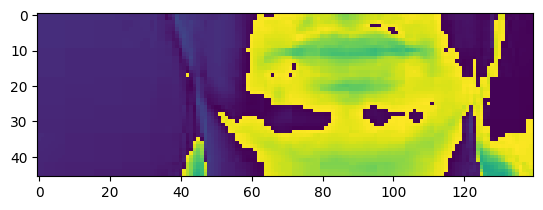

In [35]:
# 0: videos, 0: 1st video out of the batch, 0: return the first frame in the video
plt.imshow(val[0][0][0])

In [36]:
tf.strings.reduce_join([num_to_char(word) for word in val [1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green by c eight please'>

# 3. Design the Deep Neural Network

In [37]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [38]:
char_to_num.vocabulary_size()

40

In [39]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [41]:
5*17*75

6375

In [42]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [43]:
yhat[0]

array([[0.02217816, 0.02424627, 0.02743653, ..., 0.03034321, 0.02831897,
        0.02660671],
       [0.02180896, 0.02454946, 0.027661  , ..., 0.03095555, 0.02869166,
        0.02673078],
       [0.02164765, 0.02494244, 0.02743179, ..., 0.03155288, 0.02891784,
        0.02674804],
       ...,
       [0.02216496, 0.02955573, 0.0236554 , ..., 0.02771424, 0.02689545,
        0.02354872],
       [0.02273326, 0.03000962, 0.02330931, ..., 0.0265312 , 0.02622669,
        0.02365515],
       [0.02355325, 0.03042709, 0.02299356, ..., 0.02554639, 0.02545946,
        0.02382753]], dtype=float32)

In [44]:
yhat[0].shape

(75, 41)

In [45]:
tf.argmax(yhat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18], dtype=int64)>

In [46]:
[num_to_char(x) for x in tf.argmax(yhat[0], axis=1)]

[<tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,


In [47]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr'>

In [48]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr'>

In [49]:
model.input_shape

(None, 75, 46, 140, 1)

In [50]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [51]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [52]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [53]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [54]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [55]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [56]:
schedule_callback = LearningRateScheduler(scheduler)

In [57]:
#Run Again this query
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [58]:
example_callback = ProduceExample(test)

In [59]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1yyUrZAUvegKF4uylg_sftBINDF_bdnoh&export=download&confirm=t&uuid=4e807f50-62cc-4f88-a6c4-1620af5a8eca'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [62]:
optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.load_weights('models/checkpoint')

In [63]:
test_data = test.as_numpy_iterator()

In [64]:
sample = test_data.next()

In [65]:
yhat = model.predict(sample[0])

1/1 [==============================] - 4s 4s/step


In [66]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green by r two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white by d six now'>]

In [67]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [68]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green by r two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white by d six now'>]

# 6. Test on a Video

In [69]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [70]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [71]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [72]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [73]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

The model can predict the lip read in the video without audio its absolute amazing.